## Solution to the second project

#### All the imports here

In [1]:
import numpy as np
from numpy import linspace, vstack, zeros, arange, power, abs
from scipy.stats import multivariate_normal as mn
from scipy.stats import pearsonr
from numpy.linalg import inv
import random
from time import time
from pprint import pformat
from collections import namedtuple
from operator import itemgetter

#### Making matplotlib more tolerable

In [2]:
import matplotlib.pyplot as plt
%pylab inline
plt.xkcd();

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


### Plotting functions below

In [3]:
#plotting functions here

### Task 2.1 (yobibyte)

In [4]:
def custom_fit(x, y, deg):
    res_x = np.ones(len(x))
    for i in range(1, deg+1):
        res_x = np.vstack((res_x, x**i))
    x_tr = res_x
    x_ntr = np.transpose(res_x)
    # return np.flipud(np.dot(np.dot(inv(np.dot(x_tr, x_ntr)), x_tr), y))
    return np.flipud(np.dot(np.linalg.pinv(x_ntr),y))
    # return np.polyfit(x,y,deg)

/Users/yobibyte/dev/patternrecognition/pr/lib/python2.7/site-packages/numpy/lib/polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


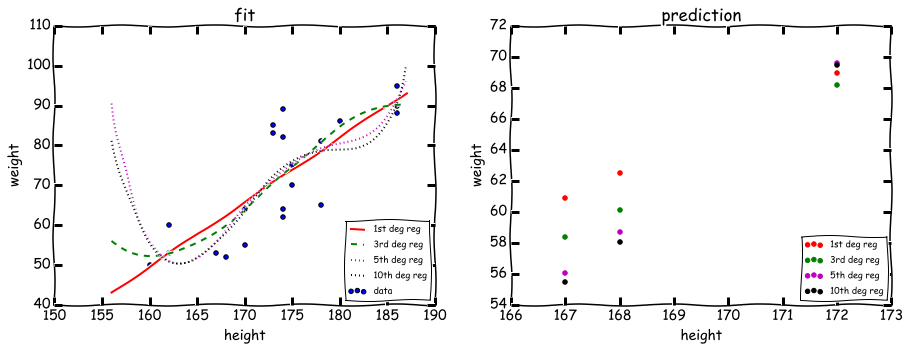

In [5]:
dt = np.dtype([('w', np.float), ('h', np.float), ('g', 'S1')])
data = np.loadtxt('resources/whData.dat', dtype=dt, comments='#', delimiter=None)

ws = data['w']
hs = data['h']
gs = np.array([el.decode('utf-8') for el in data['g']])

hs_t = hs[np.where(ws < 0)]
gs_t = gs[np.where(ws < 0)]
ws_t = ws[np.where(ws < 0)]

hs = np.delete(hs, np.where(ws < 0), None)
gs = np.delete(gs, np.where(ws < 0), None)
ws = np.delete(ws, np.where(ws < 0), None)

p = np.poly1d(custom_fit(hs,ws,1))
p_lib = np.poly1d(np.polyfit(hs,ws,1))
p3 = np.poly1d(custom_fit(hs,ws,3))
p_lib3 = np.poly1d(np.polyfit(hs,ws,3))
p5 = np.poly1d(custom_fit(hs,ws,5))
p10 = np.poly1d(custom_fit(hs,ws,10))
p_lib10 = np.poly1d(np.polyfit(hs,ws,10))
xp = np.linspace(156, 187, 100)

colors = ['r'if el=='f' else 'b' for el in gs]

fig,axes = subplots(ncols=2, figsize=(15,5))
ax = axes[0]
ax2 = axes[1]

ax.set_title('fit')
ax.set_xlabel('height')
ax.set_ylabel('weight')
ax.scatter(hs, ws, label='data')
ax.plot(xp, p(xp), '-', label='1st deg reg', color='r')
ax.plot(xp, p3(xp), '--', label='3rd deg reg',color='g')
ax.plot(xp, p5(xp), ':', label='5th deg reg',color='m')
ax.plot(xp, p10(xp), ':', label='10th deg reg',color='k')
legend = ax.legend(loc='lower right', prop={'size':9})

ax2.set_ylabel('weight')
ax2.set_xlabel('height')
ax2.set_title('prediction')
ax2.scatter(hs_t, p(hs_t), label='1st deg reg', color='r')
ax2.scatter(hs_t, p3(hs_t), label='3rd deg reg',color='g')
ax2.scatter(hs_t, p5(hs_t), label='5th deg reg',color='m')
ax2.scatter(hs_t, p10(hs_t), label='10th deg reg',color='k')
legend = ax2.legend(loc='lower right', prop={'size':9})

### Task 2.2 (yakun)

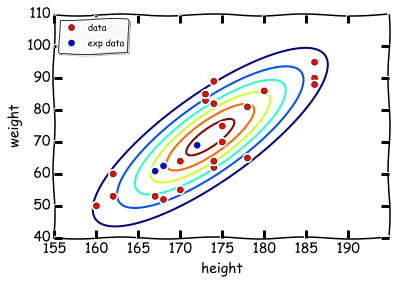

In [6]:
# get the mean, std variance, variance of height, and weight data
h_mean, h_std, h_var = np.mean(hs), np.std(hs), np.var(hs)
w_mean, w_std, w_var = np.mean(ws), np.std(ws), np.var(ws)

# get the correlation between height and weight
correlation_h_w = pearsonr(hs, ws)[0]

# get the joint mean and covariance matrix for bivariate gaussian
joint_mean = np.array([h_mean, w_mean])
joint_cov = np.mat([[h_var, correlation_h_w * h_std * w_std], [correlation_h_w * h_std * w_std, w_var]])

# get predict of the outliers
exp_w = [w_mean + correlation_h_w * (w_std / h_std) * (el - h_mean) for el in hs_t]

# set the x, y axis
x, y = np.mgrid[155:195:0.1, 40:110:0.1]
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)

# set the pos for generating the gaussian pdf
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x
pos[:, :, 1] = y
rv = mn.pdf(pos, joint_mean, joint_cov)

# plot the results
ax2.contour(x, y, rv)
X = np.vstack((hs, ws))
Pre = np.vstack((hs_t, exp_w))
ax2.plot(X[0, :], X[1, :], 'ro', label='data')
ax2.plot(Pre[0, :], Pre[1, :], 'ro', label='exp data', color='blue')

# label the graph
ax2.set_ylabel('weight')
ax2.set_xlabel('height')

# add legend
leg = ax2.legend(loc='upper left', shadow=True, fancybox=True, numpoints=1, prop={'size':9})
leg.get_frame().set_alpha(0.8)

### Task 2.3 (yakun)

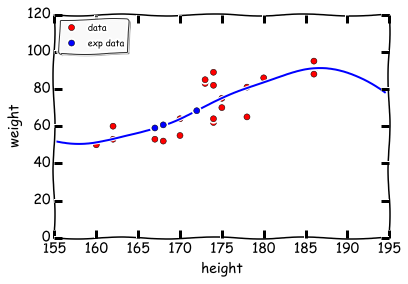

In [7]:
# x->hs, y->ws, get max pro weights 
X = np.array([np.array([np.power(x, 0), np.power(x, 1), np.power(x, 2), np.power(x, 3), np.power(x, 4), np.power(x, 5)]) for x in hs])
mat_inv = inv(np.dot(X.transpose(), X) + (h_var / 3) * np.identity(6))
w_map = np.dot(np.dot(mat_inv, X.transpose()), ws)

# set x, y axis
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.set_xlim([155, 195])
ax2.set_ylim([0, 120])

# plot regression
x = np.arange(155, 195, 0.5)
re = w_map[0] * np.power(x, 0) + w_map[1] * np.power(x, 1) + w_map[2] * np.power(x, 2) + w_map[3] * np.power(x, 3) + w_map[4] * np.power(x, 4) + w_map[5] * np.power(x, 5)
ax2.plot(hs, ws, 'ro', label='data')
ax2.plot(x, re)

# plot outliers
outliers = [w_map[0] * np.power(x, 0) + w_map[1] * np.power(x, 1) + w_map[2] * np.power(x, 2) + w_map[3] * np.power(x, 3) + w_map[4] * np.power(x, 4) + w_map[5] * np.power(x, 5) for x in hs_t]
ax2.plot(hs_t, outliers, 'ro', label='exp data', color='blue')

# label the graph
ax2.set_ylabel('weight')
ax2.set_xlabel('height')

# add legend
leg = ax2.legend(loc='upper left', shadow=True, fancybox=True, numpoints=1, prop={'size':9})
leg.get_frame().set_alpha(0.8)

### Task 2.4 (yobibyte)

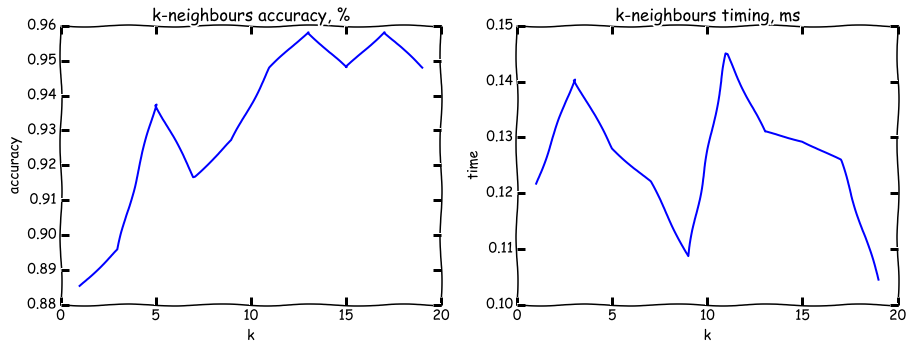

In [8]:
n = [1,3,5,7,9,11,13,15,17,19]

dt = np.dtype([('x1', np.float), ('x2', np.float), ('y',  np.float)])

data = np.loadtxt('resources/data2-train.dat', dtype=dt, comments='#', delimiter=None)
Xtr,ytr = np.array([[el[0],el[1]] for el in data]),data['y']

data = np.loadtxt('resources/data2-test.dat', dtype=dt, comments='#', delimiter=None)
Xt,yt = np.array([[el[0],el[1]] for el in data]),data['y']

#k-neighbours train is just storing the train data
#that is already done

#test
preds = []
timing = []
for k in n:
    st_t = time()
    curr_pred = []
    
    for p in Xt:
        dist = [np.abs(np.linalg.norm(tr-p)) for tr in Xtr]
        neighbours = np.argsort(dist)[:k]
    timing.append(time()-st_t)
    
    for p in Xt:    
        dist = [np.abs(np.linalg.norm(tr-p)) for tr in Xtr]
        neighbours = np.argsort(dist)[:k]
        n_vals = ytr[neighbours]
        #hey! will be strange for even k's
        pred = 1.0 if sum(n_vals) > 0 else -1.0
        curr_pred.append(pred)
    preds.append(curr_pred)
    
acc = []
for p in preds:
    corr = [int(i)==int(j) for i,j in zip(yt,p)]
    corr = sum(corr)/(1.0*len(corr))
    acc.append(corr)  
    
fig,axes = subplots(ncols=2, figsize=(15,5))
ax = axes[0]
ax2 = axes[1]

ax.set_title('k-neighbours accuracy, %')
ax.set_xlabel('k')
ax.set_ylabel('accuracy')
ax.plot(n, acc);    

ax2.set_title('k-neighbours timing, ms')
ax2.set_xlabel('k')
ax2.set_ylabel('time')
ax2.plot(n, timing);

### Task 2.5

In [9]:
class Node(namedtuple('Node', 'location left_child right_child')):
    def __repr__(self):
        return pformat(tuple(self))

# line width for visualization of K-D tree
line_width = [4., 3.5, 3., 2.5, 2., 1.5, 1., .5, 0.3]


def plot_tree(tree, min_x, max_x, min_y, max_y, prev_node, branch, depth=0):
    """ plot K-D tree
    :param tree      input tree to be plotted
    :param min_x
    :param max_x
    :param min_y
    :param max_y
    :param prev_node parent's node
    :param branch    True if left, False if right
    :param depth     tree's depth
    :return tree     node
    """

    cur_node = tree.location         # current tree's node
    left_branch = tree.left_child    # its left branch
    right_branch = tree.right_child  # its right branch

    # set line's width depending on tree's depth

    if depth > len(line_width)-1:
        ln_width = line_width[len(line_width)-1]
    else:
        ln_width = line_width[depth]

    k = len(cur_node)
    axis = depth % k

    # draw a vertical splitting line
    if axis == 0:

        if branch is not None and prev_node is not None:

            if branch:
                max_y = prev_node[1]
            else:
                min_y = prev_node[1]

        plt.plot([cur_node[0],cur_node[0]], [min_y,max_y], linestyle='-', color='red', linewidth=ln_width)

    # draw a horizontal splitting line
    elif axis == 1:

        if branch is not None and prev_node is not None:

            if branch:
                max_x = prev_node[0]
            else:
                min_x = prev_node[0]

        plt.plot([min_x,max_x], [cur_node[1],cur_node[1]], linestyle='-', color='blue', linewidth=ln_width)

    # draw the current node
    plt.plot(cur_node[0], cur_node[1], 'ko')

    # draw left and right branches of the current node
    if left_branch is not None:
        plot_tree(left_branch, min_x, max_x, min_y, max_y, cur_node, True, depth+1)

    if right_branch is not None:
        plot_tree(right_branch, min_x, max_x, min_y, max_y, cur_node, False, depth+1)


def get_data_list(option, fileWithData ):
    dt = np.dtype([('x1', np.float), ('x2', np.float), ('y',  np.float)])
    data = np.loadtxt( fileWithData , dtype=dt, comments='#', delimiter=None)
    Xtr,ytr = np.array([[el[0],el[1]] for el in data]),data['y']
    if option == 'x':
        pass
    elif option == 'y':
        Xtr[:,[0, 1]] = Xtr[:,[1, 0]]
    elif option == 'variance':
        if np.var(np.array(data['x1'])) < np.var(np.array(data['x2'])):
            Xtr[:,[0, 1]] = Xtr[:,[1, 0]]
    else:
        raise ValueError('dimension for splitting should be "x", "y" or "variance".')

    nested_lst_of_tuples = [tuple(l) for l in Xtr]
    return nested_lst_of_tuples



def query_kd_tree(tree, p, depth):
    #dist = [np.abs(np.linalg.norm(tr-p)) for tr in Xtr]
    cur_node = tree.location         # current tree's node
    left_branch = tree.left_child    # its left branch
    right_branch = tree.right_child  # its right branch

    vertHoriz = 0
    if ( depth%2 == 0 ):
        vertHoriz = 0
    else:
        vertHoriz = 1

    depth += 1
    if ( p[vertHoriz] <= cur_node[vertHoriz] ):
        if left_branch is None:
            return cur_node
        else:
            return query_kd_tree(left_branch, p, depth)
    else:
        if right_branch is None:
            return cur_node
        else:
            return query_kd_tree(right_branch, p, depth)

   

def kdtree(point_list, pivot, depth=0):
    try:
        k = len(point_list[0]) # assumes all points have the same dimension
    except IndexError as e: # if not point_list:
        return None

    # Select axis based on depth so that axis cycles through all valid values
    axis = depth % k

    # Sort point list
    point_list.sort(key=itemgetter(axis))

    # compute median as pivot element
    median = len(point_list) // 2

    # compute midpoint as pivot element
    axis_value_list = [pair[axis] for pair in point_list]
    mean_value = sum(axis_value_list) / float(len(point_list))
    mean_pos = (np.abs(np.array(axis_value_list)-mean_value)).argmin()

    # Create node and construct subtrees
    if pivot == 'median':
        return Node(
            location=point_list[median],
            left_child=kdtree(point_list[:median], pivot, depth + 1),
            right_child=kdtree(point_list[median + 1:], pivot, depth + 1)
        )
    elif pivot == 'midpoint':
       return Node(
            location=point_list[mean_pos],
            left_child=kdtree(point_list[:mean_pos], pivot, depth + 1),
            right_child=kdtree(point_list[mean_pos + 1:], pivot, depth + 1)
        )
    else:
        raise ValueError('pivot value should be "median" or "midpoint".')



def kdtree_execute_options( spliting_dimension , spliting_point ):
    delta = 1
    # get the point list by specifing the x, y dimension or by variance
    point_list = get_data_list( spliting_dimension , 'resources/data2-train.dat')

    x_max_val, y_max_val = int(map(max, zip(*point_list))[0]), int(map(max, zip(*point_list))[1])
    x_min_val, y_min_val = int(map(min, zip(*point_list))[0]), int(map(min, zip(*point_list))[1])
    tree = kdtree(point_list, spliting_point)

    plt.figure("K-d Tree", figsize=(10., 10.))
    plt.axis( [x_min_val-delta, x_max_val+delta, y_min_val-delta, y_max_val+delta] )

    plt.grid(b=True, which='major', color='0.75', linestyle='--')
    plt.xticks([i for i in range(x_min_val-delta, x_max_val+delta, 4)])
    plt.yticks([i for i in range(y_min_val-delta, y_max_val+delta, 4)])

    # draw the tree
    plot_tree(tree, x_min_val-delta, x_max_val+delta, y_min_val-delta, y_max_val+delta, None, None)

    plt.title('K-D Tree')
    plt.show()
    plt.close()

    return tree

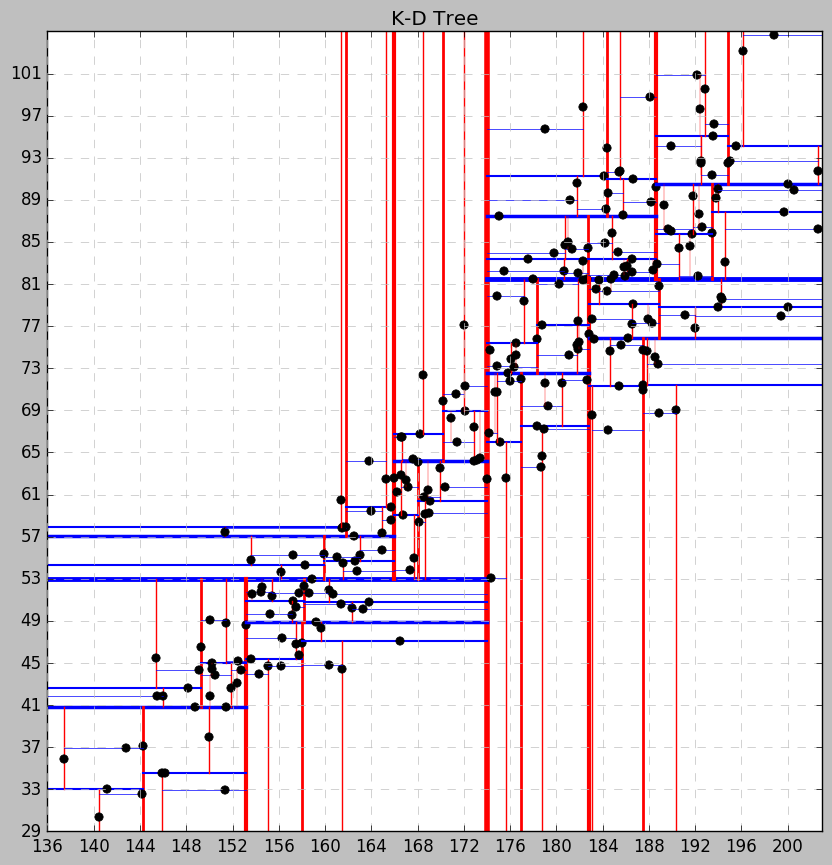

0.000917911529541


In [10]:
plt.rcdefaults() #with xkcd style the graph is too messy

tree = kdtree_execute_options('x', 'midpoint')
#tree = kdtree_execute_options('y', 'midpoint')
#tree = kdtree_execute_options('variance', 'midpoint')

#tree = kdtree_execute_options('x', 'median')
#tree = kdtree_execute_options('y', 'median')
#tree = kdtree_execute_options('variance', 'median')

# Overall run time
dt = np.dtype([('x1', np.float), ('x2', np.float), ('y',  np.float)])
data = np.loadtxt('resources/data2-test.dat', dtype=dt, comments='#', delimiter=None)
Xt,yt = np.array([[el[0],el[1]] for el in data]),data['y']

data = np.loadtxt('resources/data2-train.dat', dtype=dt, comments='#', delimiter=None)
Xtr,ytr = np.array([[el[0],el[1]] for el in data]),data['y']

#k-neighbours train is just storing the train data
#that is already done
#test
timing = 0.0
st_t = time()
for p in Xt:
    neighbour = query_kd_tree(tree, p, 0)
timing = time()-st_t 
    
print timing